In [1]:
from nldg.utils import *
from nldg.rf import MaggingRF
from adaXT.random_forest import RandomForest
import copy
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.metrics import mean_squared_error
from itertools import product
from scipy.stats import dirichlet
from collections import defaultdict

NAME_RF = "WORME-RF"

## Comparison with Magging

In [2]:
demean_setting = 2
dtr = gen_data_v3(n=1000, setting=2)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr_orig = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
random_state = 42
min_samples_leaf = 15

if demean_setting == 1:
    Ytr = Ytr_orig
    demean = False
elif demean_setting == 2:  # center the data in each environment
    Ytr = np.zeros_like(Ytr_orig)
    for env in np.unique(Etr):
        idx = Etr == env
        Ytr[idx] = Ytr_orig[idx] - np.mean(Ytr_orig[idx])
        demean = True

In [3]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xtr)
preds_rf = rf.predict(Xtr_sorted)
min_xplvar(Ytr, fitted_rf, Etr, demean=demean, verbose=True)

Environment 0 explained variance: 8.434015991779598
Environment 1 explained variance: 2.0186800303153625
Environment 2 explained variance: 3.5926215139898305


np.float64(2.0186800303153625)

In [4]:
rf.modify_predictions_trees(Etr, method="xplvar", verbose=True)
fitted_xv = rf.predict(Xtr)
preds_xv = rf.predict(Xtr_sorted)
min_xplvar(Ytr, fitted_xv, Etr, demean=demean, verbose=True)

Initial score: -2.211970
Optimized score: -3.064143
Environment 0 explained variance: 6.53204706728571
Environment 1 explained variance: 3.5329890253349667
Environment 2 explained variance: 3.054009654234518


np.float64(3.054009654234518)

In [5]:
rf_magging = MaggingRF(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
)
fitted_magging, preds_magging = rf_magging.fit_predict_magging(Xtr, Ytr, Etr, Xtr_sorted)
wmag = rf_magging.get_weights()

min_xplvar(Ytr, fitted_magging, Etr, demean=demean, verbose=True)

Environment 0 explained variance: 3.723962590666975
Environment 1 explained variance: -26.131661941523568
Environment 2 explained variance: -0.9843995103232004


np.float64(-26.131661941523568)

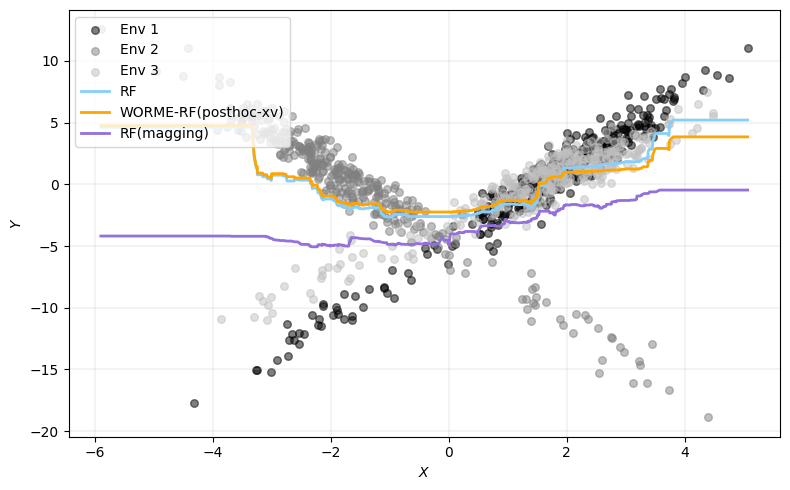

In [7]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_minmax"] = preds_xv
dtr["fitted_magging"] = preds_magging
dtr["Y"] = Ytr

plot_dtr(dtr, saveplot=True, nameplot="setting2_magging_comparison", suffix="posthoc-xv")

## Extragradient Method: Different Objectives

In [8]:
demean_setting = 1
dtr = gen_data_v5(n_samples=1000, adv_fraction=0.1, noise_var_env2=2, setting=2)

Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr_orig = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
random_state = 42
min_samples_leaf = 30

if demean_setting == 1:
    Ytr = Ytr_orig
    demean = False
elif demean_setting == 2:
    Ytr = np.zeros_like(Ytr_orig)
    for env in np.unique(Etr):
        idx = Etr == env
        Ytr[idx] = Ytr_orig[idx] - np.mean(Ytr_orig[idx])
        demean = True

# Fit standard RF for each environment separately.
# This is used for the regret
sols_erm = np.zeros(Etr.shape[0])
sols_erm_trees = np.zeros((n_estimators, Etr.shape[0]))
for env in np.unique(Etr):
    mask = Etr == env
    X_e = Xtr[mask]
    Y_e = Ytr[mask]
    rf_e = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state
    )
    rf_e.fit(X_e, Y_e)
    fitted_e = rf_e.predict(X_e)
    sols_erm[mask] = fitted_e
    for i in range(n_estimators):
        fitted_e_tree = rf_e.trees[i].predict(X_e)
        sols_erm_trees[i, mask] = fitted_e_tree

In [9]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xtr)
preds_rf = rf.predict(Xtr_sorted)

mse_rf, _ = max_mse(Ytr, fitted_rf, Etr, ret_ind=True)
xv_rf, _ = min_xplvar(Ytr, fitted_rf, Etr, demean=demean, ret_ind=True)
regret_rf, _ = max_regret(Ytr, fitted_rf, sols_erm, Etr, ret_ind=True)

In [ ]:
rf.modify_predictions_trees(Etr, opt_method="extragradient")  # can try verbose=True
fitted_mse = rf.predict(Xtr)
preds_mse = rf.predict(Xtr_sorted)

mse_mse, _ = max_mse(Ytr, fitted_mse, Etr, ret_ind=True)
xv_mse, _ = min_xplvar(Ytr, fitted_mse, Etr, demean=demean, ret_ind=True)
regret_mse, _ = max_regret(Ytr, fitted_mse, sols_erm, Etr, ret_ind=True)

In [ ]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf.fit(Xtr, Ytr)
rf.modify_predictions_trees(Etr, method="xplvar",
                            opt_method="extragradient")
fitted_xv = rf.predict(Xtr)
preds_xv = rf.predict(Xtr_sorted)

mse_xv, _ = max_mse(Ytr, fitted_xv, Etr, ret_ind=True)
xv_xv, _ = min_xplvar(Ytr, fitted_xv, Etr, demean=demean, ret_ind=True)
regret_xv, _ = max_regret(Ytr, fitted_xv, sols_erm, Etr, ret_ind=True)

In [ ]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf.fit(Xtr, Ytr)
rf.modify_predictions_trees(
    Etr,
    method="regret",
    sols_erm=sols_erm,
    sols_erm_trees=sols_erm_trees,
    opt_method="extragradient",
    # verbose=True,
)
fitted_regret = rf.predict(Xtr)
preds_regret = rf.predict(Xtr_sorted)

mse_regret, _ = max_mse(Ytr, fitted_regret, Etr, ret_ind=True)
xv_regret, _ = min_xplvar(Ytr, fitted_regret, Etr, demean=demean, ret_ind=True)
regret_regret, _ = max_regret(Ytr, fitted_regret, sols_erm, Etr, ret_ind=True)

In [13]:
rf_magging = MaggingRF(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
)
fitted_magging, preds_magging = rf_magging.fit_predict_magging(Xtr, Ytr, Etr, Xtr_sorted)
wmag = rf_magging.get_weights()

mse_magging, _ = max_mse(Ytr, fitted_magging, Etr, ret_ind=True)
xv_magging, _ = min_xplvar(Ytr, fitted_magging, Etr, demean=demean, ret_ind=True)
regret_magging, _ = max_regret(Ytr, fitted_magging, sols_erm, Etr, ret_ind=True)

In [14]:
cols = pd.MultiIndex.from_product(
    [["MSE", "Xpl Var", "Regret"], ["0", "1"]],
    names=["Metric", "Env"]
)
data = [
    [round(float(x), 3) for x in mse_rf + xv_rf + regret_rf],
    [round(float(x), 3) for x in mse_mse + xv_mse + regret_mse],
    [round(float(x), 3) for x in mse_xv + xv_xv + regret_xv],
    [round(float(x), 3) for x in mse_regret + xv_regret + regret_regret],
    [round(float(x), 3) for x in mse_magging + xv_magging + regret_magging],
]
df = pd.DataFrame(
    data,
    index=
    [
        "RF",
        f"{NAME_RF}(posthoc-mse)",
        f"{NAME_RF}(posthoc-xv)",
        f"{NAME_RF}(posthoc-regret)",
        "RF(magging)"
    ],
    columns=cols)
print(df)

Metric                      MSE         Xpl Var        Regret        
Env                           0       1       0      1      0       1
RF                        0.407  17.513   0.309  1.793  0.154  12.925
WORME-RF(posthoc-mse)     5.991   6.803  -0.048  2.719  5.738   2.215
WORME-RF(posthoc-xv)      0.267  20.749   0.311  1.492  0.014  16.161
WORME-RF(posthoc-regret)  3.559   9.090   0.114  2.499  3.305   4.502
RF(magging)               0.253  20.874   0.325  1.572  0.000  16.286


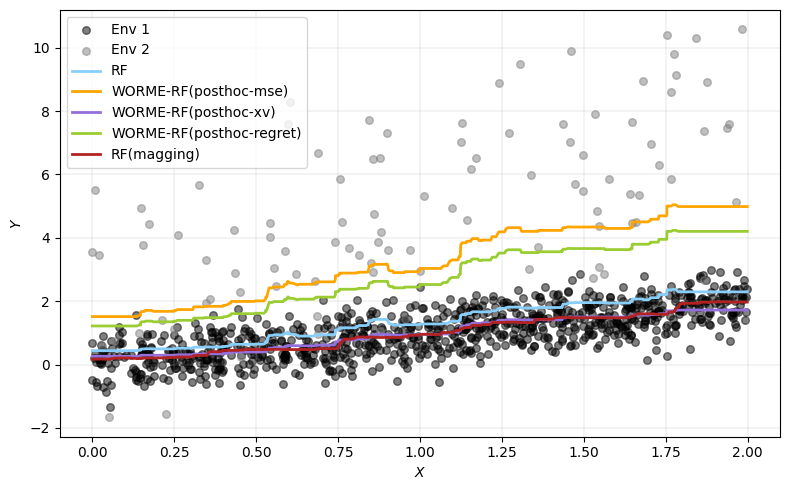

In [15]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_mse"] = preds_mse
dtr["fitted_xv"] = preds_xv
dtr["fitted_regret"] = preds_regret
dtr["fitted_magging"] = preds_magging
dtr["Y"] = Ytr

plot_dtr(dtr, obj_comparison=True)

## Generalization Gap

In [20]:
d = 1
E = 3
n_train_per_env = [1000, 500, 500]
n_test = 500
sigma_eps  = 0.1
kernel = ConstantKernel(1.0) * RBF(length_scale=0.5)
SEED = 42
rng = np.random.default_rng(SEED)

def sample_gp_function(x_grid):
    K = kernel(x_grid, x_grid)
    f_vals = rng.multivariate_normal(np.zeros(len(x_grid)), K)
    return lambda x: np.interp(x.ravel(), x_grid.ravel(), f_vals)

x_grid = np.linspace(-1, 1, 1000).reshape(-1, 1)
f_env  = [sample_gp_function(x_grid) for _ in range(E)]

def make_dataset(f, env_id, n_samples):
    X = rng.uniform(-1, 1, size=(n_samples, d))
    eps = rng.normal(0, sigma_eps, size=n_samples)
    y_noise = f(X) + eps
    env_lab = np.full(n_samples, env_id)
    return X, y_noise, env_lab

train_sets = [
    make_dataset(f_env[e], env_id=e, n_samples=n_train_per_env[e])
    for e in range(E)
]

X_tr = np.vstack([ts[0] for ts in train_sets])
y_tr = np.hstack([ts[1] for ts in train_sets])
env_label = np.hstack([ts[2] for ts in train_sets])

w = dirichlet.rvs(alpha=np.ones(E), random_state=rng).ravel()
f_test = lambda x: sum(w[e] * f_env[e](x) for e in range(E))
X_te = rng.uniform(-1, 1, size=(n_test, d))
eps_te = rng.normal(0, sigma_eps, size=n_test)
y_te_clean = f_test(X_te)
y_te = y_te_clean + eps_te

In [21]:
n_estimators = 50
random_state = 42
min_samples_leaf = 20
X_tr_sorted = np.sort(X_tr, axis=0)

sols_erm = np.zeros(env_label.shape[0])
sols_erm_trees = np.zeros((n_estimators, env_label.shape[0]))
for env in np.unique(env_label):
    mask = env_label == env
    X_e = X_tr[mask]
    Y_e = y_tr[mask]
    rf_e = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state
    )
    rf_e.fit(X_e, Y_e)
    fitted_e = rf_e.predict(X_e)
    sols_erm[mask] = fitted_e
    for i in range(n_estimators):
        fitted_e_tree = rf_e.trees[i].predict(X_e)
        sols_erm_trees[i, mask] = fitted_e_tree

rf_mse = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf_mse.fit(X_tr, y_tr)
fitted_tr_rf = rf_mse.predict(X_tr)
preds_tr_rf = rf_mse.predict(X_tr_sorted)
mse_rf, _ = max_mse(y_tr, fitted_tr_rf, env_label, ret_ind=True)
xv_rf, _ = min_xplvar(y_tr, fitted_tr_rf, env_label, demean=True, ret_ind=True)
regret_rf, _ = max_regret(y_tr, fitted_tr_rf, sols_erm, env_label, ret_ind=True)

In [22]:
rf_mse.modify_predictions_trees(env_label)
fitted_tr_mse = rf_mse.predict(X_tr)
preds_tr_mse = rf_mse.predict(X_tr_sorted)

mse_mse, _ = max_mse(y_tr, fitted_tr_mse, env_label, ret_ind=True)
xv_mse, _ = min_xplvar(y_tr, fitted_tr_mse, env_label, demean=True, ret_ind=True)
regret_mse, _ = max_regret(y_tr, fitted_tr_mse, sols_erm, env_label, ret_ind=True)

In [23]:
rf_xv = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf_xv.fit(X_tr, y_tr)
rf_xv.modify_predictions_trees(env_label, method="xplvar")
fitted_tr_xv = rf_xv.predict(X_tr)
preds_tr_xv = rf_xv.predict(X_tr_sorted)

mse_xv, _ = max_mse(y_tr, fitted_tr_xv, env_label, ret_ind=True)
xv_xv, _ = min_xplvar(y_tr, fitted_tr_xv, env_label, demean=True, ret_ind=True)
regret_xv, _ = max_regret(y_tr, fitted_tr_xv, sols_erm, env_label, ret_ind=True)

In [24]:
rf_regret = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state
)
rf_regret.fit(X_tr, y_tr)
rf_regret.modify_predictions_trees(
    env_label,
    method="regret",
    sols_erm=sols_erm,
    sols_erm_trees=sols_erm_trees
)
fitted_tr_regret = rf_regret.predict(X_tr)
preds_tr_regret = rf_regret.predict(X_tr_sorted)

mse_regret, _ = max_mse(y_tr, fitted_tr_regret, env_label, ret_ind=True)
xv_regret, _ = min_xplvar(y_tr, fitted_tr_regret, env_label, demean=True, ret_ind=True)
regret_regret, _ = max_regret(y_tr, fitted_tr_regret, sols_erm, env_label, ret_ind=True)

In [25]:
cols = pd.MultiIndex.from_product(
    [["MSE", "Xpl Var", "Regret"], ["0", "1", "2"]],
    names=["Metric", "Env"]
)
data = [
    [round(float(x), 3) for x in mse_rf + xv_rf + regret_rf],
    [round(float(x), 3) for x in mse_mse + xv_mse + regret_mse],
    [round(float(x), 3) for x in mse_xv + xv_xv + regret_xv],
    [round(float(x), 3) for x in mse_regret + xv_regret + regret_regret],
]
df = pd.DataFrame(
    data,
    index=
    [
        "RF",
        f"{NAME_RF}(posthoc-mse)",
        f"{NAME_RF}(posthoc-xv)",
        f"{NAME_RF}(posthoc-regret)",
    ],
    columns=cols)
print(df)

Metric                      MSE               Xpl Var               Regret  \
Env                           0      1      2       0      1      2      0   
RF                        0.080  0.107  0.140   0.439  0.110  0.161  0.071   
WORME-RF(posthoc-mse)     0.102  0.102  0.108   0.417  0.115  0.193  0.093   
WORME-RF(posthoc-xv)      0.294  0.022  0.109   0.225  0.195  0.192  0.285   
WORME-RF(posthoc-regret)  0.101  0.102  0.109   0.418  0.115  0.192  0.092   

Metric                                  
Env                           1      2  
RF                        0.096  0.130  
WORME-RF(posthoc-mse)     0.092  0.098  
WORME-RF(posthoc-xv)      0.012  0.099  
WORME-RF(posthoc-regret)  0.092  0.099  


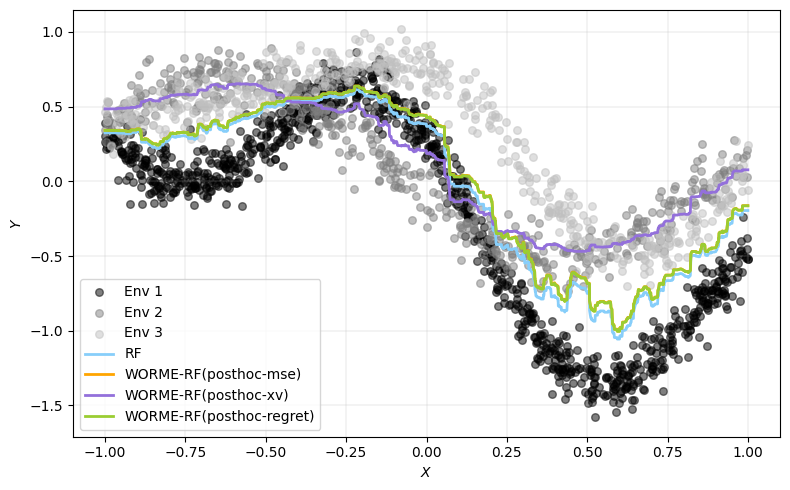

In [43]:
dtr = pd.DataFrame({
    "X": X_tr.ravel(),
    "Y": y_tr.ravel(),
    "E": env_label.ravel(),
    "X_sorted": X_tr_sorted.ravel(),
    "fitted_rf": preds_tr_rf.ravel(),
    "fitted_mse": preds_tr_mse.ravel(),
    "fitted_xv": preds_tr_xv.ravel(),
    "fitted_regret": preds_tr_regret.ravel(),
})

plot_dtr(dtr, obj_comparison=True, legend_pos=None)

In [26]:
fitted_te_mse = rf_mse.predict(X_te)
fitted_te_xv = rf_xv.predict(X_te)
fitted_te_regret = rf_regret.predict(X_te)
# Compute metric for each training environment using f_env[e] on test inputs
mse_per_env, xv_per_env, regret_per_env = [], [], []
for e in range(E):
    y_env = f_env[e](X_te) + eps_te

    mse = mean_squared_error(y_env, fitted_te_mse)
    mse_per_env.append(mse)

    xv = mean_squared_error(y_env, fitted_te_xv) - np.mean(y_env ** 2)
    xv_per_env.append(xv)

    rf_e = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state,
    )
    rf_e.fit(X_te, y_env)
    sols_erm_e = rf_e.predict(X_te)
    regret = mean_squared_error(y_env, fitted_te_xv) - mean_squared_error(y_env, sols_erm_e)
    regret_per_env.append(regret)

max_mse_train = max(mse_per_env)
max_xv_train = max(xv_per_env)
max_regret_train = max(regret_per_env)

In [28]:
grid_size = 15
q1_vals = np.linspace(0, 1, grid_size)
q2_vals = np.linspace(0, 1, grid_size)
results_mse, results_xv, results_regret = [], [], []
mse_diff_map, xv_diff_map, regret_diff_map = (
        defaultdict(list),
        defaultdict(list),
        defaultdict(list),
)

for q1, q2 in product(q1_vals, q2_vals):
    if q1 + q2 > 1:
        continue
    q3 = 1 - q1 - q2
    q = [q1, q2, q3]
    f_test = lambda x: sum(q[e] * f_env[e](x) for e in range(E))
    y_te = f_test(X_te) + eps_te

    mse = mean_squared_error(y_te, fitted_te_mse)
    results_mse.append((q1, q2, mse - max_mse_train))
    mse_diff_map[(q1, q2)].append(mse - max_mse_train)

    xv = mean_squared_error(y_te, fitted_te_mse) - np.mean(y_te ** 2)
    results_xv.append((q1, q2, xv - max_xv_train))
    xv_diff_map[(q1, q2)].append(xv - max_xv_train)

    rf_te = RandomForest(
        "Regression",
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        seed=random_state,
    )
    rf_te.fit(X_te, y_te)
    sols_erm_te = rf_te.predict(X_te)
    regret = mean_squared_error(y_te, fitted_te_mse) - mean_squared_error(y_te, sols_erm_te)
    results_xv.append((q1, q2, regret - max_regret_train))
    regret_diff_map[(q1, q2)].append(regret - max_regret_train)

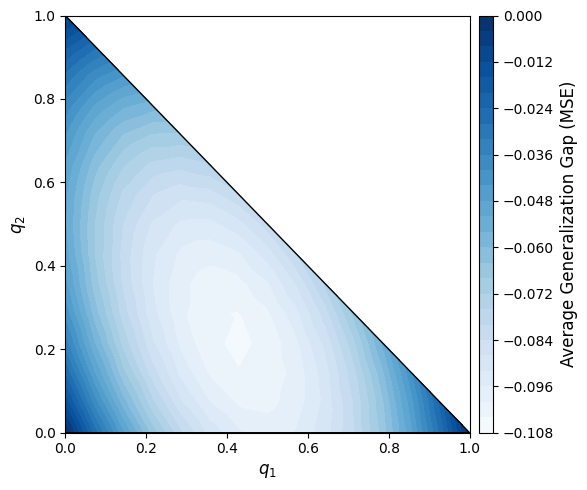

In [31]:
plot_tricontour(mse_diff_map, "mse")

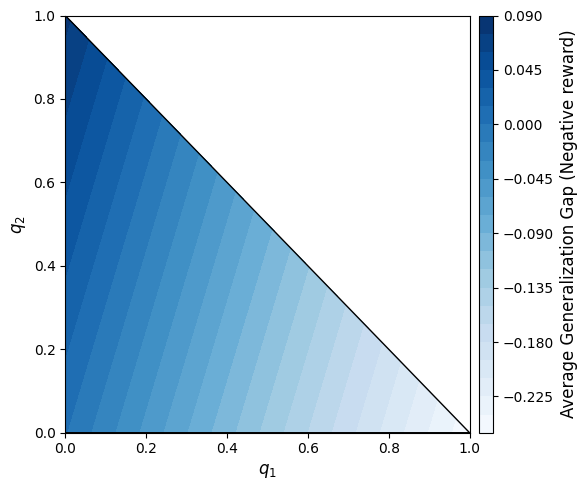

In [32]:
plot_tricontour(xv_diff_map, "negrew")

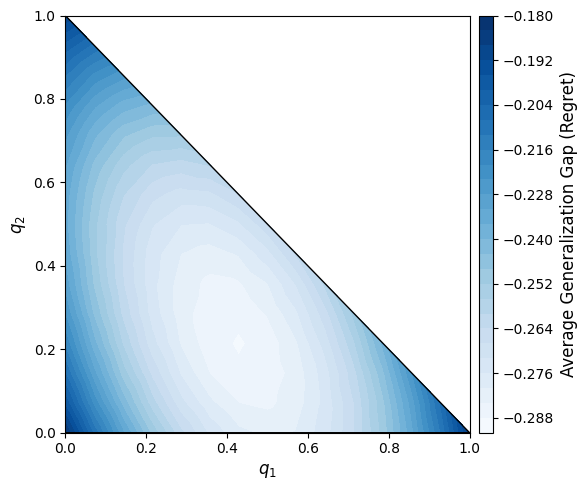

In [33]:
plot_tricontour(regret_diff_map, "regret")

## When is the MSE not the right metric to use?

In [47]:
d = 1
E = 3
n = 500
kernel = ConstantKernel(1.0) * RBF(length_scale=0.3)
SEED = 0
rng = np.random.default_rng(SEED)

X = rng.uniform(-1, 1, size=(n, d))


def sample_gp_function(x_grid):
    K = kernel(x_grid, x_grid)
    f_vals = rng.multivariate_normal(np.zeros(len(x_grid)), K)
    return lambda x: np.interp(x.ravel(), x_grid.ravel(), f_vals)

x_grid = np.linspace(-1, 1, 1000).reshape(-1, 1)
f_env  = [sample_gp_function(x_grid) for _ in range(E)]

def make_dataset(f, env_id, n_samples):
    y_clean  = f(X)
    env_lab  = np.full(n_samples, env_id)
    return X, y_clean, env_lab

train_sets = [
    make_dataset(f_env[e], env_id=e, n_samples=n)
    for e in range(E)
]

X_tr = np.vstack([ts[0] for ts in train_sets])
y_tr_clean = np.hstack([ts[1] for ts in train_sets])
env_label = np.hstack([ts[2] for ts in train_sets])

In [48]:
# Let the third environment be the noisiest one
# Compute, for each environment e != 2, E[(f^e(X)-f^{2}(X))^2]
k = 2
mask_k = env_label == k
max_delta = 0
for e in range(E):
    if e != k:
        mask = env_label == e
        delta = np.mean((y_tr_clean[mask] - y_tr_clean[mask_k]) ** 2)
        print(delta)
        max_delta = max(max_delta, delta)

1.0732257818118405
2.369945596720329


In [49]:
# Therefore, if sigma = sigma_0 = sigma_1 = 0.1,
# we need to choose sigma_2^2 >= max_delta + sigma^2
y_tr = copy.deepcopy(y_tr_clean)
sigma = 0.1
sigma_max = np.sqrt(max_delta + sigma**2)
eps = rng.normal(0, sigma, size=n)
eps_max = rng.normal(0, sigma_max, size=n)
for e in range(E):
    mask = env_label == e
    if e != k:
        y_tr[mask] += eps
    else:
        y_tr[mask] += eps_max

In [50]:
n_estimators = 50
random_state = 42
min_samples_leaf = 25
X_tr_sorted = np.sort(X_tr, axis=0)

rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(X_tr, y_tr)
fitted_rf = rf.predict(X_tr)
preds_rf = rf.predict(X_tr_sorted)
max_mse(y_tr, fitted_rf, env_label, verbose=True)

Environment 0 MSE: 0.3630862210447386
Environment 1 MSE: 0.7211974585434714
Environment 2 MSE: 2.7401707836004285


np.float64(2.7401707836004285)

In [51]:
rf.modify_predictions_trees(env_label, verbose=True)
fitted_minmax = rf.predict(X_tr)
preds_minmax = rf.predict(X_tr_sorted)
max_mse_train = max_mse(y_tr, fitted_minmax, env_label)
max_mse(y_tr, fitted_minmax, env_label, verbose=True)

Initial score: 2.740171
Optimized score: 2.245468
Environment 0 MSE: 0.7187047468811388
Environment 1 MSE: 1.7397423210806426
Environment 2 MSE: 2.2454681417231988


np.float64(2.2454681417231988)

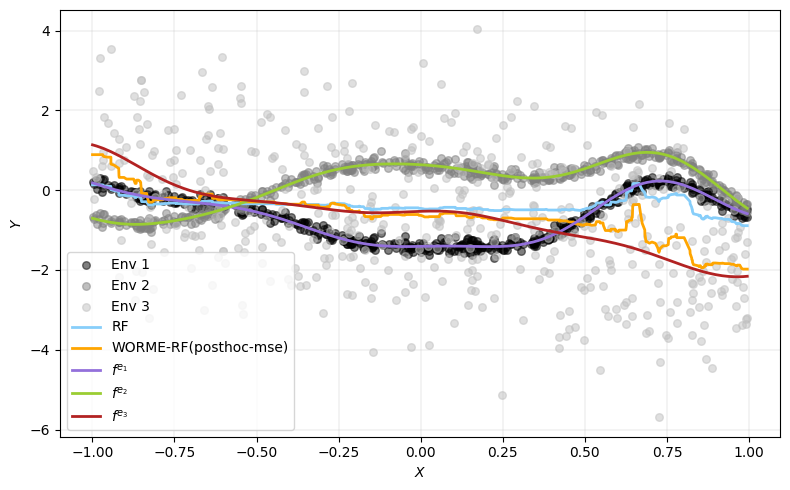

In [83]:
dtr = pd.DataFrame({
    "X": X_tr.ravel(),
    "Y": y_tr.ravel(),
    "E": env_label.ravel(),
    "X_sorted": X_tr_sorted.ravel(),
    "fitted_rf": preds_rf.ravel(),
    "fitted_minmax": preds_minmax.ravel(),
    "y_clean": y_tr_clean,
})

plot_dtr(dtr, suffix="posthoc-mse", legend_pos=None)